In [1]:
#Set up the environment
library(reshape2)
library(tidyverse)
library(janitor) #has the rownames_to_column function
library(ggrepel)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test




In [2]:
#Load in the lineage-corrected ancestry-associated p-value data frame
setwd("../data")
lineage.corrected.pvals = read.table("lm_ancestry_associated_dependency_pvals.txt", sep = "\t", header = T)

head(lineage.corrected.pvals)

,gene,afr.lm.pval.vector,amr.lm.pval.vector,eas.lm.pval.vector,eur.lm.pval.vector,sas.lm.pval.vector,afr.mean.dif,amr.mean.dif,eas.mean.dif,eur.mean.dif,sas.mean.dif,afr_fdr,amr_fdr,eas_fdr,eur_fdr,sas_fdr
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,A1BG,0.51570812,0.5243904,0.33508618,0.51316820,1.0000000,0.018967685,0.039100054,-0.011154457,0.006603833,-0.226423809,0.998556,1,0.9184664,0.9703296,1
2,A1CF,0.09749307,0.9998859,0.73471568,0.70146509,0.5597664,-0.035117475,0.027514943,-0.002246655,0.007144719,0.030043081,0.998556,1,0.9771815,0.9821999,1
3,A2M,0.68035925,1.0000000,0.51713036,0.53660729,1.0000000,-0.010031350,0.038566520,-0.001514329,0.001920044,0.046502802,0.998556,1,0.9548815,0.9720597,1
4,A2ML1,0.61602149,0.6843036,0.09231594,0.06193838,1.0000000,0.009988105,0.013638286,0.009534186,-0.010934267,0.004499364,0.998556,1,0.7843746,0.8105684,1
5,A3GALT2,0.76637396,1.0000000,0.70909158,0.83017049,0.9866729,0.003320528,0.001137803,-0.016077768,0.014507092,-0.002840530,0.998556,1,0.9753693,0.9917531,1
6,A4GALT,0.87370145,1.0000000,0.13340200,0.13581386,1.0000000,0.004528391,0.019587428,-0.008987721,0.008747816,-0.096587268,0.998556,1,0.8209225,0.8739186,1


In [3]:
#Calculate the number of significant associations per ancestry group
num.sig.afr = lineage.corrected.pvals %>% filter(afr_fdr < 0.05) %>% nrow()
num.sig.amr = lineage.corrected.pvals %>% filter(amr_fdr < 0.05) %>% nrow()
num.sig.eas = lineage.corrected.pvals %>% filter(eas_fdr < 0.05) %>% nrow()
num.sig.eur = lineage.corrected.pvals %>% filter(eur_fdr < 0.05) %>% nrow()
num.sig.sas = lineage.corrected.pvals %>% filter(sas_fdr < 0.05) %>% nrow()
num.sig.any = lineage.corrected.pvals %>% filter(afr_fdr < 0.05 | amr_fdr < 0.05 | eas_fdr < 0.05 | eur_fdr < 0.05 | sas_fdr < 0.05) %>% pull(gene) %>% unique() %>% length()

In [4]:
#Print the data so that we can add this information to the paper
print(paste("the number of significant AFR genes is:", num.sig.afr))
print(paste("the number of significant AMR genes is:", num.sig.amr))
print(paste("the number of significant EAS genes is:", num.sig.eas))
print(paste("the number of significant EUR genes is:", num.sig.eur))
print(paste("the number of significant SAS genes is:", num.sig.sas))
print(paste("the number of significant genes (in any ancestry) is:", num.sig.any))

#Calculate the number of genes that are shared between eas and eur
eas.sig.gene.vector = lineage.corrected.pvals %>% filter(eas_fdr < 0.05) %>% pull(gene) %>% unique()
eur.sig.gene.vector = lineage.corrected.pvals %>% filter(eur_fdr < 0.05) %>% pull(gene) %>% unique()
eas.eur.intersection = intersect(eas.sig.gene.vector, eur.sig.gene.vector) %>% length()
print(paste("the number of intersecting EAS and EUR genes is:", eas.eur.intersection))

[1] "the number of significant AFR genes is: 24"
[1] "the number of significant AMR genes is: 3"
[1] "the number of significant EAS genes is: 18"
[1] "the number of significant EUR genes is: 17"
[1] "the number of significant SAS genes is: 1"
[1] "the number of significant genes (in any ancestry) is: 49"
[1] "the number of intersecting EAS and EUR genes is: 13"


In [6]:
#Write the plotting df to a file
df_for_plotting = cbind(ancestry.vector, num.gene.vector) %>%
data.frame() %>%
rename("ancestry" = 1, "num_genes" = 2) %>%
mutate(num_genes = as.numeric(num_genes))

setwd("../output")
write.table(df_for_plotting, "figure_1e_data.txt", sep = "\t", row.names = F, col.names = TRUE, quote = FALSE)

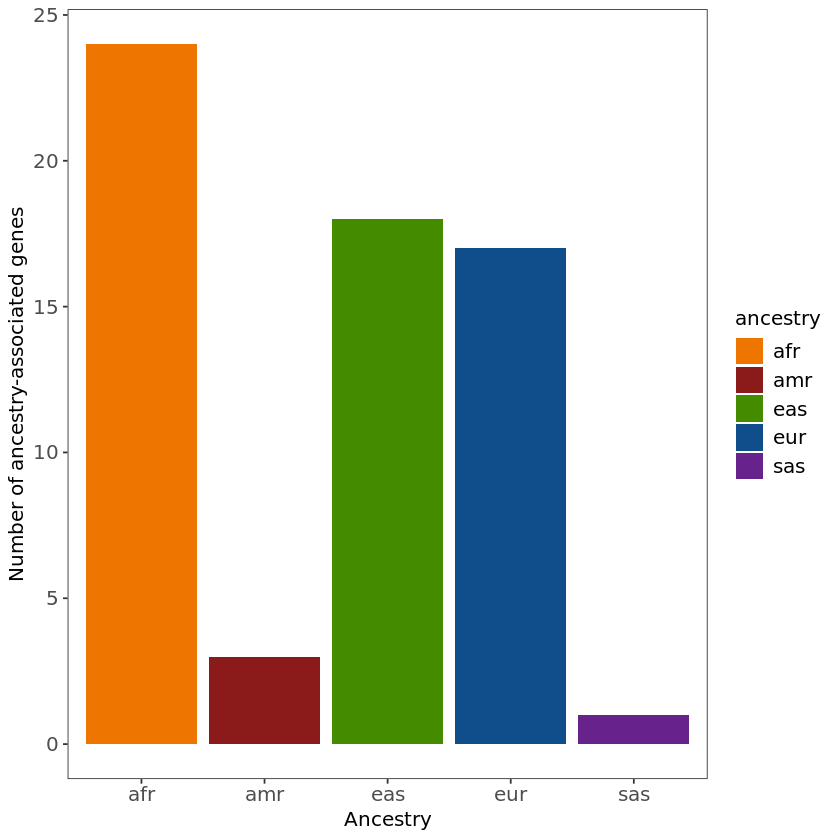

In [5]:
#Plot the data
num.gene.vector = c(num.sig.afr, num.sig.amr, num.sig.eas, num.sig.eur, num.sig.sas) 
ancestry.vector = c("afr", "amr", "eas", "eur", "sas")

cbind(ancestry.vector, num.gene.vector) %>%
data.frame() %>%
rename("ancestry" = 1, "num_genes" = 2) %>%
mutate(num_genes = as.numeric(num_genes)) %>%
ggplot(aes(x = ancestry, y = num_genes, fill = ancestry)) +
geom_bar(stat = "identity") +

theme_bw() +

scale_fill_manual(values = c("darkorange2", "firebrick4", "chartreuse4", "dodgerblue4", "darkorchid4")) +

theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
) +

theme(
axis.title.x = element_text(color = "black", size = 12),
axis.title.y = element_text(color = "black", size = 12)
) +

theme(
axis.text = element_text(size = 12),
axis.title = element_text(size = 12)
) +

theme(
legend.title = element_text(size = 12),
legend.text = element_text(size = 12)
) +

ylab("Number of ancestry-associated genes") +
xlab("Ancestry")

#Export it to the google bucket
setwd("../output")
ggsave("figure_1e.pdf", width = 3, height = 3)
